Import and Install Python and AWS libraries

In [ ]:
pip install python-utils

In [ ]:
pip install utils

In [162]:
import sys
import os
import shutil

import pandas as pd
print('pandas: {}'.format(pd.__version__))
# display all columns wide
pd.set_option('display.max_columns', None)
# display all rows long
pd.set_option('display.max_rows', None)
# display horizontal scrollbar for wide columns
pd.set_option('display.width', 5000)
pd.set_option('display.max_colwidth', 5000)
#turn off scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import numpy as np
print('numpy: {}'.format(np.__version__))
import matplotlib.pyplot as plt
%matplotlib inline 


# get region from boto3
import boto3
REGION = boto3.Session().region_name

# importing forecast notebook utility from notebooks/common directory
sys.path.insert( 0, os.path.abspath("../../common") )
import utils

pandas: 1.0.1
numpy: 1.20.3


In [163]:
#########
# Function to concat .part files in predictor backtest file export folder
#########

def read_backtest_predictions(BUCKET_NAME, s3_path):
    """Read predictor backtest predictions export files
       Inputs: 
           BUCKET_NAME = S3 bucket name
           s3_path = S3 path to Predictor.part files
                         , everything after "s3://BUCKET_NAME/" in S3 URI path to your .part files
       Return: Pandas dataframe with all .part files concatenated row-wise
    """
    # set s3 path
    s3 = boto3.resource('s3')
    s3_bucket = boto3.resource('s3').Bucket(BUCKET_NAME)
    s3_depth = s3_path.split("/")
    s3_depth = len(s3_depth) - 1
    print("s3_bucket is {} and s3_depth is ",format(s3_bucket))
    
    # set local path
    local_write_path = "backtest_exports"
    if (os.path.exists(local_write_path) and os.path.isdir(local_write_path)):
        shutil.rmtree('backtest_exports')
    if not(os.path.exists(local_write_path) and os.path.isdir(local_write_path)):
        os.makedirs(local_write_path)
    
    # concat part files
    part_filename = ""
    part_files = list(s3_bucket.objects.filter(Prefix=s3_path))
    print(f"Number _part files found: {len(part_files)}")
    for file in part_files:
        # There will be a collection of CSVs if the forecast is large, modify this to go get them all
        if "csv" in file.key:
            part_filename = file.key.split('/')[s3_depth]
            print("part file name is {}".format(part_filename))
            window_object = s3.Object(BUCKET_NAME, file.key)
            file_size = window_object.content_length
            if file_size > 0:
                s3.Bucket(BUCKET_NAME).download_file(file.key, local_write_path+"/"+part_filename)
        
    # Read from local dir and combine all the part files
    temp_dfs = []
    for entry in os.listdir(local_write_path):
        if os.path.isfile(os.path.join(local_write_path, entry)):
            df = pd.read_csv(os.path.join(local_write_path, entry), index_col=None, header=0)
            temp_dfs.append(df)

    # Return assembled .part files as pandas Dataframe
    fcst_df = pd.concat(temp_dfs, axis=0, ignore_index=True, sort=False)
    return fcst_df

def truncate_negatives_to_zero(the_df, target_value_col, quantile_cols):
    """In case you are expecting positive numbers for actuals and predictions,
       round negative values up to zero.
       
       Be careful that this is acceptable treatment of negatives for your use case.
    """
    
    df = the_df.copy()
    
    for q in quantile_cols:
        num_neg_predictions = df[q].lt(0).sum()
        print(f"Num negative {q} predictors: {num_neg_predictions}")

        # replace
        df[q] = df[q].mask(df[q] < 0, 0)

        # check you did the right thing
        num_neg_predictions = df[q].lt(0).sum()
        print(f"Num negative {q} predictors: {num_neg_predictions}")

    # truncate negative actuals
    num_neg_actuals = df[target_value_col].lt(0).sum()
    print(f"Num negative actuals: {num_neg_actuals}")

    # replace
    df[target_value_col] = df[target_value_col].mask(df[target_value_col] < 0, 0)

    # check you did the right thing
    num_neg_actuals = df[target_value_col].lt(0).sum()
    print(f"Num negative actuals: {num_neg_actuals}")
    
    return df

In [164]:
bucket_name="mitala-forecast-poc"
session = boto3.Session() 
forecast = session.client(service_name='forecast')

In [165]:
forecast.list_predictors()

{'Predictors': [{'PredictorArn': 'arn:aws:forecast:ap-south-1:593196639659:predictor/p33_only_01FSS5VGECQY42ERA0GQHZM0CX',
   'PredictorName': 'p33_only',
   'DatasetGroupArn': 'arn:aws:forecast:ap-south-1:593196639659:dataset-group/geo_new_2',
   'IsAutoPredictor': True,
   'Status': 'CREATE_STOPPED',
   'Message': 'User has requested to stop the workflow',
   'CreationTime': datetime.datetime(2022, 1, 19, 12, 44, 14, 175000, tzinfo=tzlocal()),
   'LastModificationTime': datetime.datetime(2022, 1, 19, 13, 7, 55, 679000, tzinfo=tzlocal())},
  {'PredictorArn': 'arn:aws:forecast:ap-south-1:593196639659:predictor/arima_predictor',
   'PredictorName': 'arima_predictor',
   'DatasetGroupArn': 'arn:aws:forecast:ap-south-1:593196639659:dataset-group/geo_new_2',
   'IsAutoPredictor': False,
   'Status': 'ACTIVE',
   'CreationTime': datetime.datetime(2022, 1, 19, 10, 29, 33, 621000, tzinfo=tzlocal()),
   'LastModificationTime': datetime.datetime(2022, 1, 19, 11, 45, 22, 967000, tzinfo=tzlocal()

In [166]:
s3_path_to_backtest_files = "geo_new_2/accuracy-metrics-values/"
print("path to backtest files: bucketName is {} and folderPath is {} ".format(bucket_name,s3_path_to_backtest_files))
accuracy_df = read_backtest_predictions(bucket_name, s3_path_to_backtest_files)

# keep only data rows
print(accuracy_df.shape)
accuracy_df = accuracy_df.loc[(accuracy_df.backtestwindow_start_time != "backtestwindow_start_time"), :].copy()
print(accuracy_df.shape)
accuracy_df.drop_duplicates(inplace=True)
print(accuracy_df.shape)

# correct data types
accuracy_df.item_id = accuracy_df.item_id.astype(str)
accuracy_df['backtestwindow_start_time'] = pd.to_datetime(accuracy_df['backtestwindow_start_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
accuracy_df['backtestwindow_end_time'] = pd.to_datetime(accuracy_df['backtestwindow_end_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
# convert UTC timestamp to timezone unaware
accuracy_df['backtestwindow_start_time'] = accuracy_df.backtestwindow_start_time.dt.tz_localize(None)
accuracy_df['backtestwindow_end_time'] = accuracy_df.backtestwindow_end_time.dt.tz_localize(None)

# correct dtypes
for q in accuracy_df.iloc[:, -4:].columns:
    accuracy_df[q] = pd.to_numeric(accuracy_df[q], errors='coerce')

# check
num_items = len(accuracy_df['item_id'].value_counts(normalize=True, dropna=False))
print(f"Num items: {num_items}")
print("Backtest Window Start Dates")
print(accuracy_df.backtestwindow_start_time.unique())

print(accuracy_df.dtypes)
accuracy_df.head(5)

path to backtest files: bucketName is mitala-forecast-poc and folderPath is geo_new_2/accuracy-metrics-values/ 
s3_bucket is {} and s3_depth is  s3.Bucket(name='mitala-forecast-poc')
Number _part files found: 4
part file name is Accuracy_geo_new_2_2022-01-19T11-52-03Z_part0.csv
part file name is Accuracy_geo_new_2_2022-01-19T11-52-03Z_part1.csv
part file name is Accuracy_geo_new_2_2022-01-19T11-52-03Z_part2.csv
(2, 13)
(2, 13)
(2, 13)
Num items: 1
Backtest Window Start Dates
['2021-11-26T19:15:00.000000000']
item_id                              object
backtest_window                      object
backtestwindow_start_time    datetime64[ns]
backtestwindow_end_time      datetime64[ns]
wQL[0.33]                           float64
wQL[0.5]                            float64
wQL[0.9]                            float64
wQL[0.75]                           float64
Average wQL                         float64
RMSE                                float64
WAPE                                float64
MA

,item_id,backtest_window,backtestwindow_start_time,backtestwindow_end_time,wQL[0.33],wQL[0.5],wQL[0.9],wQL[0.75],Average wQL,RMSE,WAPE,MAPE,MASE
0,1,Computed,2021-11-26 19:15:00,2021-12-02,0.14994,0.17253,0.10508,0.15805,0.14640,82.29537,30609.35544,0.18699,1.30067
1,1,Summary,2021-11-26 19:15:00,2021-12-02,0.14994,0.17253,0.10508,0.15805,0.14640,82.29537,30609.35544,0.18699,1.30067


In [167]:
# path to files is everything after BUCKET_NAME/, it should end in "/"
#s3_path_to_files = bucket_name+"/"
s3_path_to_files = ""
s3_path_to_files = s3_path_to_files + "geo_new_2/forecasted-values/"
print(f"path to files: {s3_path_to_files}")

path to files: geo_new_2/forecasted-values/


In [168]:

df = read_backtest_predictions(bucket_name, s3_path_to_files)
# df = pd.read_csv("data/bike_backtest_forecasts.csv")

# correct data types
df.item_id = df.item_id.astype(str)
df.target_value = pd.to_numeric(df.target_value, errors='coerce')
df.timestamp = pd.to_datetime(df.timestamp
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
df['backtestwindow_start_time'] = pd.to_datetime(df['backtestwindow_start_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
df['backtestwindow_end_time'] = pd.to_datetime(df['backtestwindow_end_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
# convert UTC timestamp to timezone unaware
df.timestamp = df.timestamp.dt.tz_localize(None)

# drop duplicates
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

# check
num_items = len(df['item_id'].value_counts(normalize=True, dropna=False))
print(f"Num items: {num_items}")
print()
print("Backtest Window Start Dates")
print(df.backtestwindow_start_time.unique())

print(df.dtypes)
df.head(5)

s3_bucket is {} and s3_depth is  s3.Bucket(name='mitala-forecast-poc')
Number _part files found: 3
part file name is Forecasts_geo_new_2_2022-01-19T11-51-47Z_part0.csv
part file name is Forecasts_geo_new_2_2022-01-19T11-51-47Z_part1.csv
(500, 10)
(500, 10)
Num items: 1

Backtest Window Start Dates
['2021-11-26T19:15:00.000000000']
item_id                              object
timestamp                    datetime64[ns]
target_value                        float64
backtestwindow_start_time    datetime64[ns]
backtestwindow_end_time      datetime64[ns]
p33                                 float64
p50                                 float64
p90                                 float64
mean                                float64
p75                                 float64
dtype: object


,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,p33,p50,p90,mean,p75
0,1,2021-11-26 19:15:00,273.41500,2021-11-26 19:15:00,2021-12-02,295.27148,310.46974,368.72294,313.19816,334.71257
1,1,2021-11-26 19:30:00,309.25800,2021-11-26 19:15:00,2021-12-02,323.70270,340.29828,399.97356,341.00591,367.85533
2,1,2021-11-26 19:45:00,321.34600,2021-11-26 19:15:00,2021-12-02,331.12684,346.72384,415.37458,349.96206,370.55024
3,1,2021-11-26 20:00:00,339.50600,2021-11-26 19:15:00,2021-12-02,326.60464,344.28858,415.56128,347.94070,370.80004
4,1,2021-11-26 20:15:00,291.45000,2021-11-26 19:15:00,2021-12-02,299.62691,319.87477,391.52702,324.08007,353.95057


In [169]:
# Map column names in your data to expected key words
item_id = "item_id"
target_value = "target_value"
timestamp = "timestamp"
location_id = "item_id"

In [170]:
# target = "target_value"
# set predictor dimensions from forecast df
predictor_cols = ['item_id', 'timestamp', 'rest_no', 'backtestwindow_start_time', 'backtestwindow_end_time']
# exclude cols to automatically find quantiles
exclude_cols = predictor_cols.copy()
exclude_cols.append(target_value)

# get quantile columns from forecast dataframe
quantile_cols = [c for c in df.columns if c not in exclude_cols] 
num_quantiles = len(quantile_cols)
print(f"num quantiles: {num_quantiles}")
quantile_cols

num quantiles: 5


['p33', 'p50', 'p90', 'mean', 'p75']

In [171]:
# correct data types
for q in quantile_cols:
    df[q] = pd.to_numeric(df[q], errors='coerce')

print(df.dtypes)
df.head(5)

item_id                              object
timestamp                    datetime64[ns]
target_value                        float64
backtestwindow_start_time    datetime64[ns]
backtestwindow_end_time      datetime64[ns]
p33                                 float64
p50                                 float64
p90                                 float64
mean                                float64
p75                                 float64
dtype: object


,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,p33,p50,p90,mean,p75
0,1,2021-11-26 19:15:00,273.41500,2021-11-26 19:15:00,2021-12-02,295.27148,310.46974,368.72294,313.19816,334.71257
1,1,2021-11-26 19:30:00,309.25800,2021-11-26 19:15:00,2021-12-02,323.70270,340.29828,399.97356,341.00591,367.85533
2,1,2021-11-26 19:45:00,321.34600,2021-11-26 19:15:00,2021-12-02,331.12684,346.72384,415.37458,349.96206,370.55024
3,1,2021-11-26 20:00:00,339.50600,2021-11-26 19:15:00,2021-12-02,326.60464,344.28858,415.56128,347.94070,370.80004
4,1,2021-11-26 20:15:00,291.45000,2021-11-26 19:15:00,2021-12-02,299.62691,319.87477,391.52702,324.08007,353.95057


In [172]:

### Before calling error calcs, truncate negative actuals and predictions to 0

df_eligible = df.copy()
df_eligible = truncate_negatives_to_zero(df_eligible
                                         , target_value_col=target_value
                                         , quantile_cols=quantile_cols)

Num negative p33 predictors: 0
Num negative p33 predictors: 0
Num negative p50 predictors: 0
Num negative p50 predictors: 0
Num negative p90 predictors: 0
Num negative p90 predictors: 0
Num negative mean predictors: 0
Num negative mean predictors: 0
Num negative p75 predictors: 0
Num negative p75 predictors: 0
Num negative actuals: 0
Num negative actuals: 0


In [173]:
# Add day of week for convenience
df_eligible['day_of_week'] = df_eligible.timestamp.dt.day_name()
print(df_eligible.day_of_week.value_counts())

# Add window number for convenience
windows = df_eligible.backtestwindow_start_time.value_counts().rename_axis('backtestwindow_start_time').reset_index(name='count')
windows.sort_values('backtestwindow_start_time', inplace=True)
windows.reset_index(inplace=True, drop=True)
windows.drop('count', axis=1, inplace=True)
windows['window'] = windows.index + 1

print(df_eligible.shape)
df_eligible = df_eligible.merge(windows, how="left", on="backtestwindow_start_time")
print(df_eligible.shape)
df_eligible.head(5)

Tuesday      96
Wednesday    96
Sunday       96
Monday       96
Saturday     96
Friday       19
Thursday      1
Name: day_of_week, dtype: int64
(500, 11)
(500, 12)


,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,p33,p50,p90,mean,p75,day_of_week,window
0,1,2021-11-26 19:15:00,273.41500,2021-11-26 19:15:00,2021-12-02,295.27148,310.46974,368.72294,313.19816,334.71257,Friday,1
1,1,2021-11-26 19:30:00,309.25800,2021-11-26 19:15:00,2021-12-02,323.70270,340.29828,399.97356,341.00591,367.85533,Friday,1
2,1,2021-11-26 19:45:00,321.34600,2021-11-26 19:15:00,2021-12-02,331.12684,346.72384,415.37458,349.96206,370.55024,Friday,1
3,1,2021-11-26 20:00:00,339.50600,2021-11-26 19:15:00,2021-12-02,326.60464,344.28858,415.56128,347.94070,370.80004,Friday,1
4,1,2021-11-26 20:15:00,291.45000,2021-11-26 19:15:00,2021-12-02,299.62691,319.87477,391.52702,324.08007,353.95057,Friday,1


In [174]:
quantile_cols
plot_columns = [item_id, timestamp, target_value]
plot_columns = plot_columns + quantile_cols
plot_columns
print("quantile cols -- ", quantile_cols)

quantile cols --  ['p33', 'p50', 'p90', 'mean', 'p75']


In [175]:
# instead of random top-movers, choose some fixed examples
random_items = ["2","1"]

# assemble no_weather and weather values
df_plot = df_eligible.loc[(df_eligible.item_id.isin(random_items)), plot_columns].copy()
# rename "target_value" to "actual_value" for clearer viz
df_plot.rename(columns={'target_value':'actual_value'}, inplace=True)
df_plot = df_plot.groupby([timestamp, item_id]).sum()
df_plot.reset_index(inplace=True)
df_plot.set_index(timestamp, inplace=True)
df_plot.head(2)

,item_id,actual_value,p33,p50,p90,mean,p75
timestamp,,,,,,,
2021-11-26 19:15:00,1,273.41500,295.27148,310.46974,368.72294,313.19816,334.71257
2021-11-26 19:30:00,1,309.25800,323.70270,340.29828,399.97356,341.00591,367.85533


item value to plot is 2 and item type is <class 'str'>
item value to plot is 1 and item type is <class 'str'>
0 quantile_cols j value is -- location
1 quantile_cols j value is -- p10
2 quantile_cols j value is -- p50
3 quantile_cols j value is -- p75
4 quantile_cols j value is -- mean
5 quantile_cols j value is -- p33


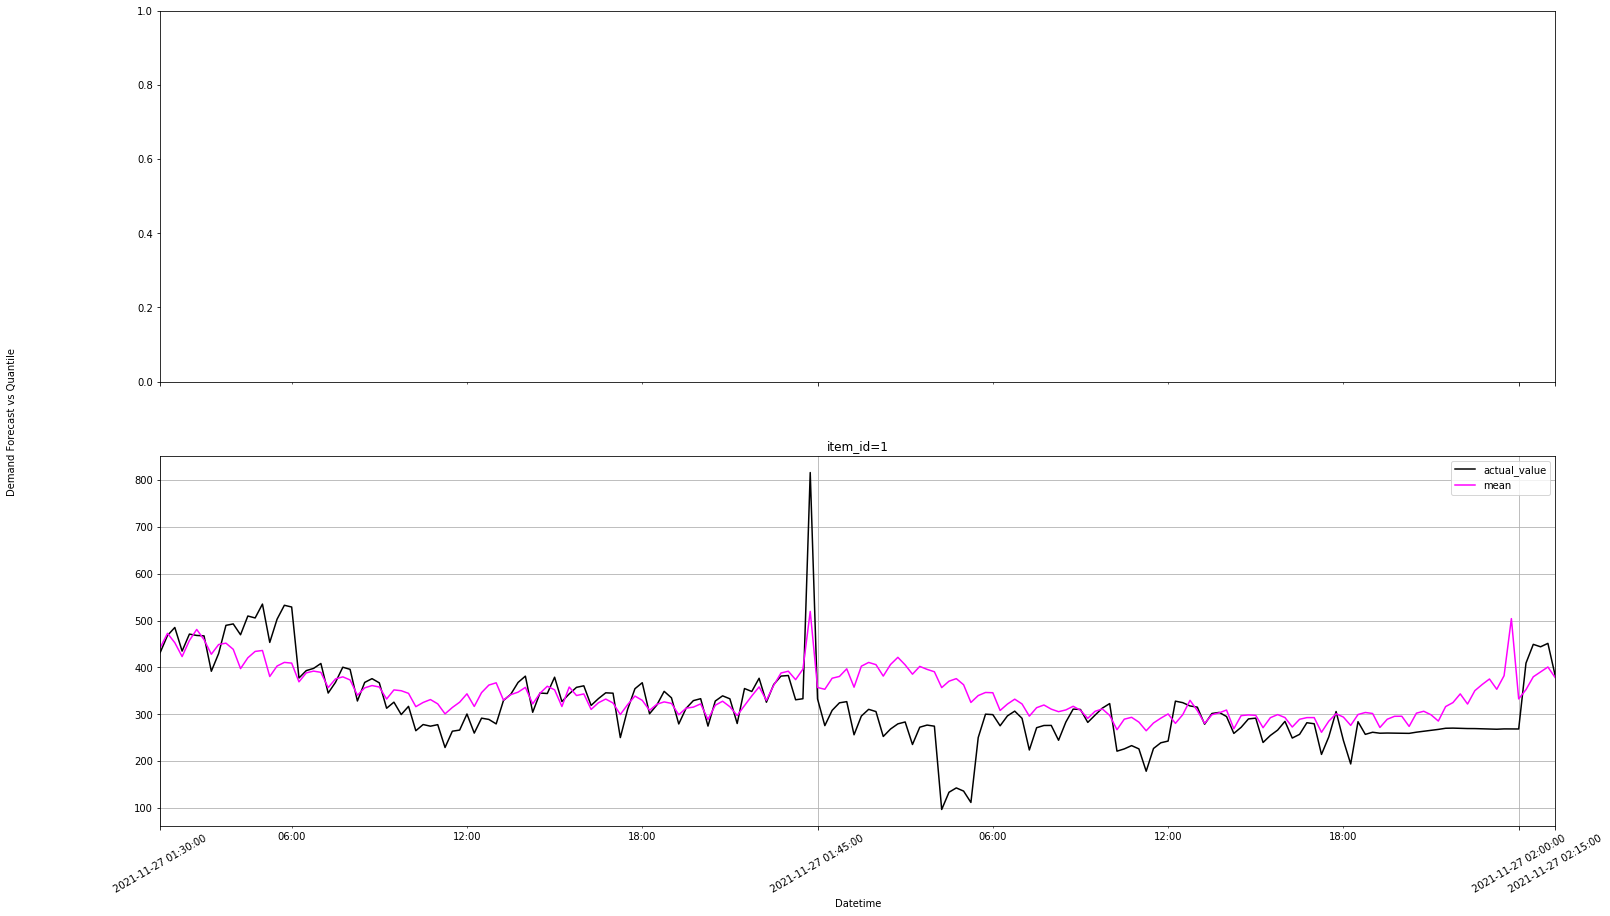

In [26]:
# Visualize items
fig, axs = plt.subplots(len(random_items), 1, figsize=(25, 15), sharex=True)

for i in range(len(random_items)):
    
    item = random_items[i]
    print("item value to plot is {} and item type is {}".format(item,type(item)))
    if item =="2":
        continue
    zoomed = df_plot.loc[(df_plot[item_id]==item), :].copy()
    zoomed[['actual_value']].plot(ax=axs[i], color='k')
    colors = ['mediumpurple', 'orange', 'deepskyblue','blue','magenta','lawngreen']
    
    for j in range(len(quantile_cols)):
        quantile = quantile_cols[j]
        print("{} quantile_cols j value is -- {}".format(j,quantile))
        if quantile !="mean":
            continue
        zoomed[[quantile]].plot(ax=axs[i], color=colors[j])
        axs[i].set_xticklabels(zoomed.index, rotation=30)
            
    axs[i].set_title(f"item_id={item}")  
    # set common Y label 
    fig.text(0.04, 0.5, 'Demand Forecast vs Quantile', va='center', rotation='vertical')
    
    # format the x ticks
    axs[i].set_xlabel("Datetime")   

        
    # format the grid
    axs[i].grid(True)
    #axs[i].grid(which='minor', axis='x')
    #axs[i].get_xaxis().set_visible(True)

item value to plot is 1 and item type is <class 'int'>


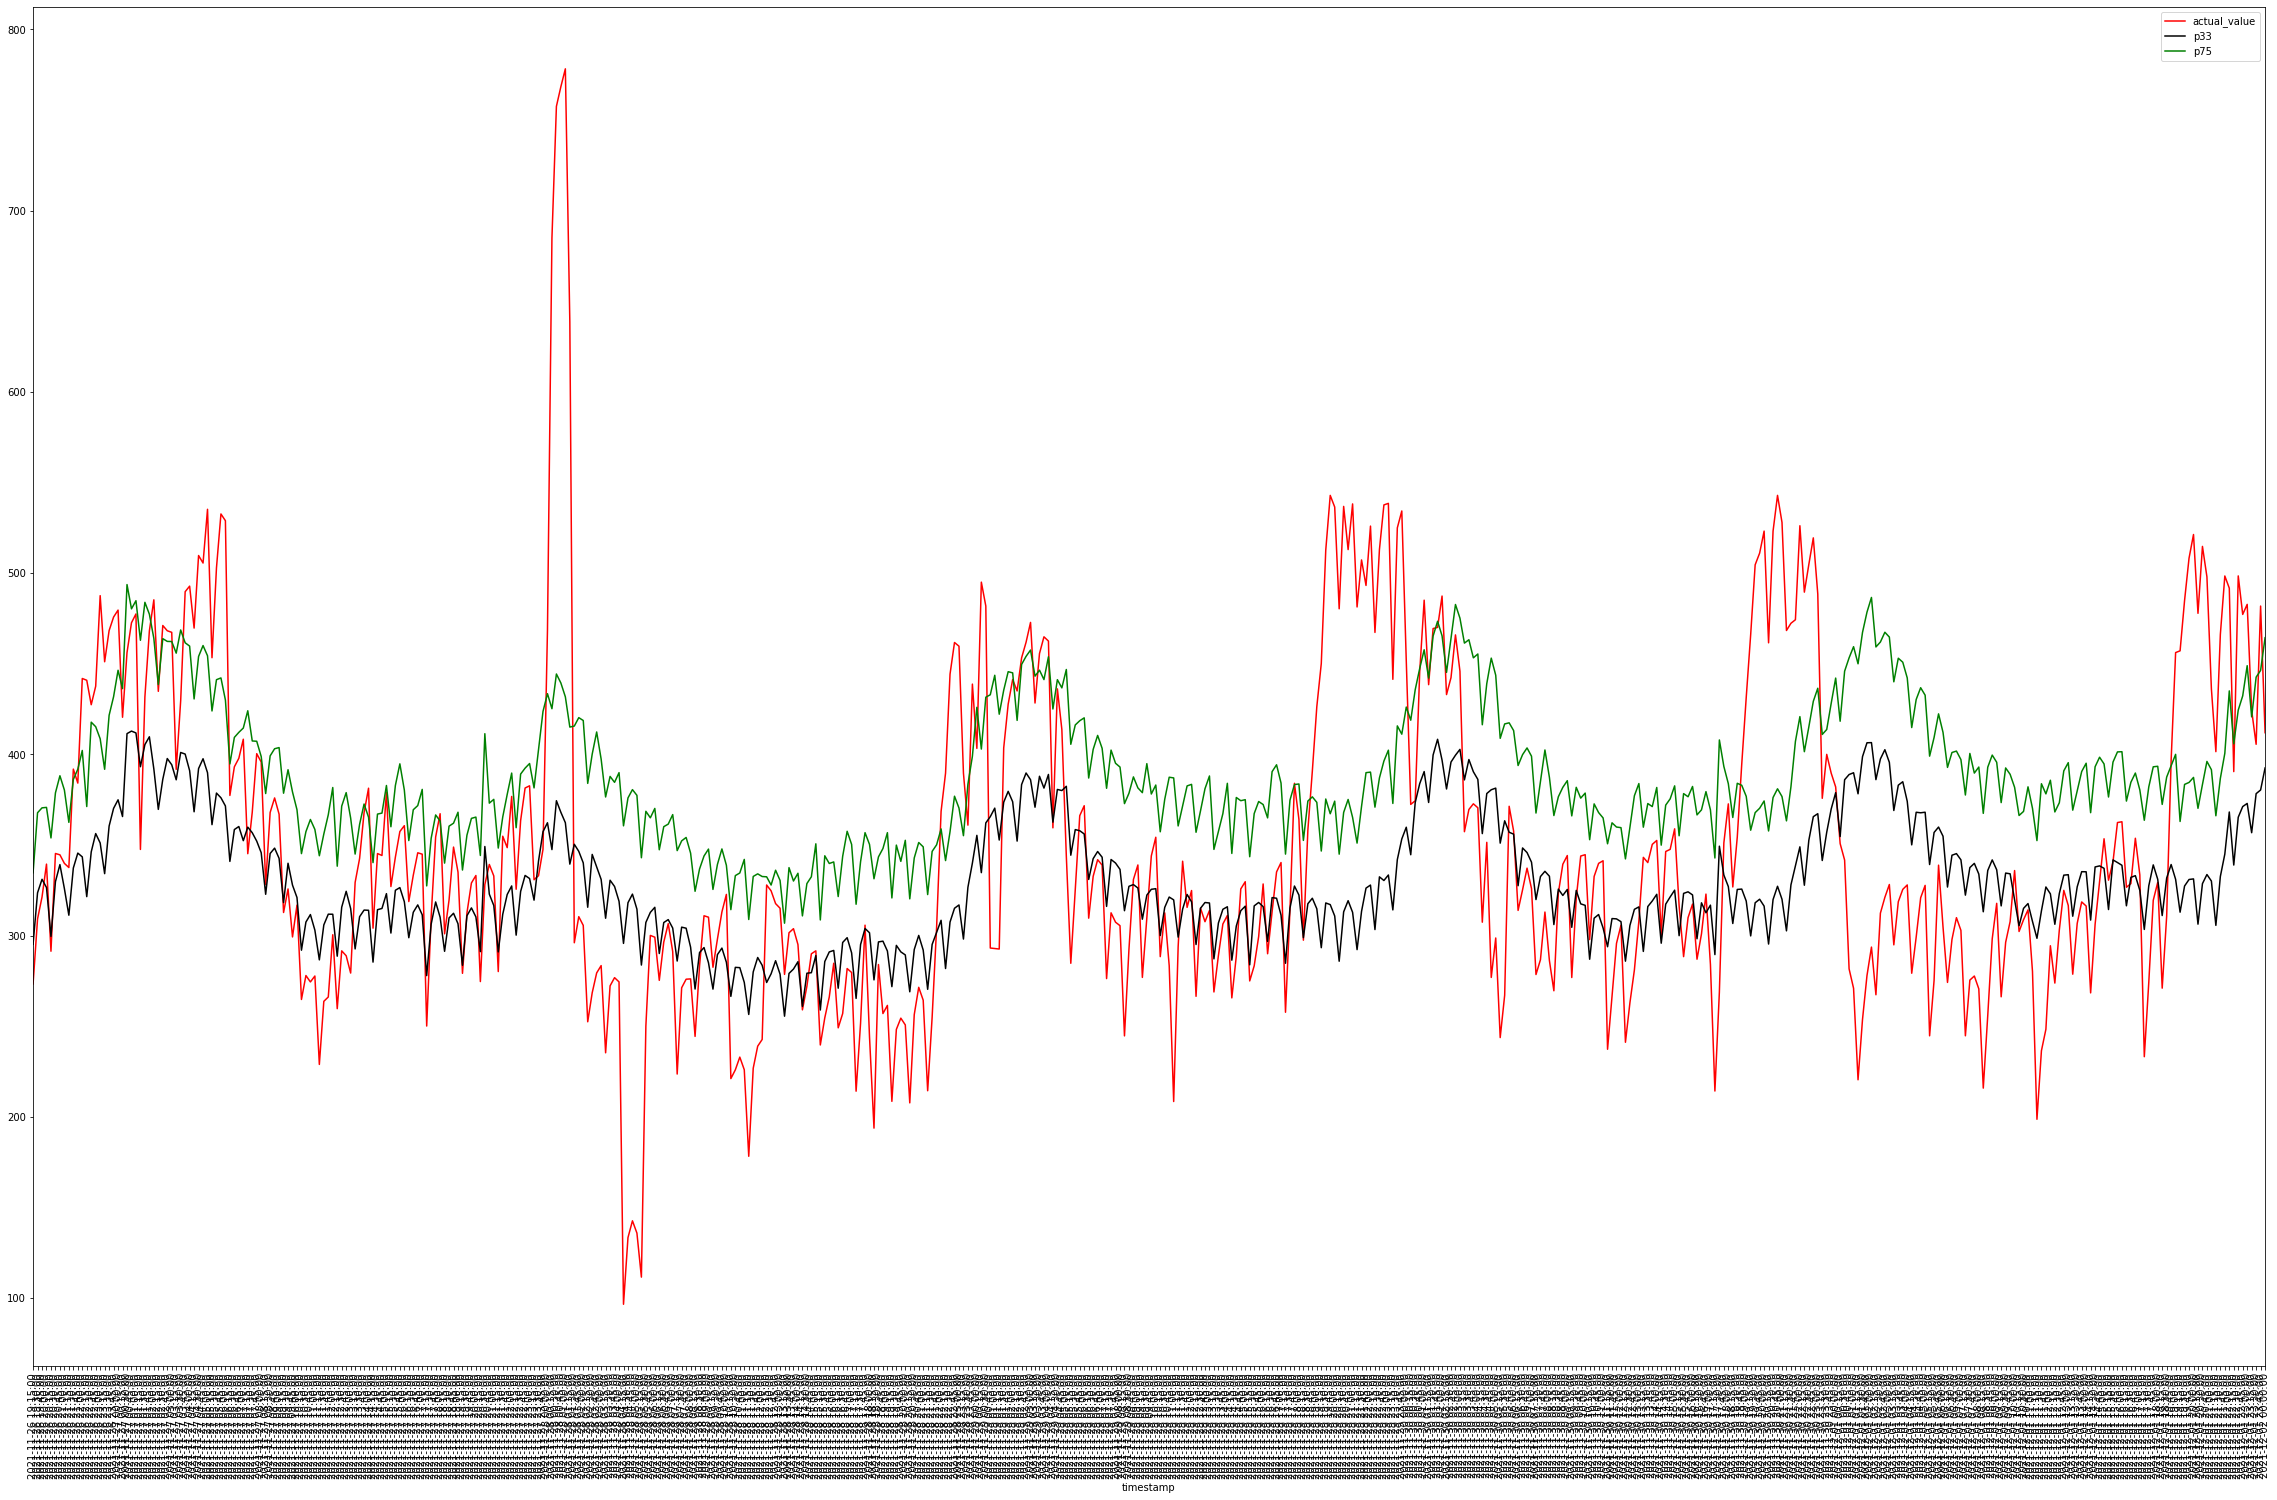

In [177]:
    
    item = 1
    print("item value to plot is {} and item type is {}".format(item,type(item)))
    #df_plot.plot(use_index=True,y=['actual_value', 'p10', 'p50', 'p75', 'mean', 'p33'],figsize=(25, 15))
    ax=df_plot.plot(use_index=True,y=['actual_value','p33','p75'],color=['red','black','green'],figsize=(40, 25))
    plt.xticks(df_plot.index,df_plot.index,rotation=90)
    plt.show()
    

/root/Forecast
total 648
-rw-r--r-- 1 root root 602402 Jan 19 05:45 ForecastPredictorAnalysis.ipynb
-rw-r--r-- 1 root root  12272 Aug  4 11:23 ImmersionDay.flow
drwxr-xr-x 2 root root   6144 Jan 19 04:55 backtest_exports
-rw-r--r-- 1 root root  38677 Jan 12 05:10 untitled.ipynb


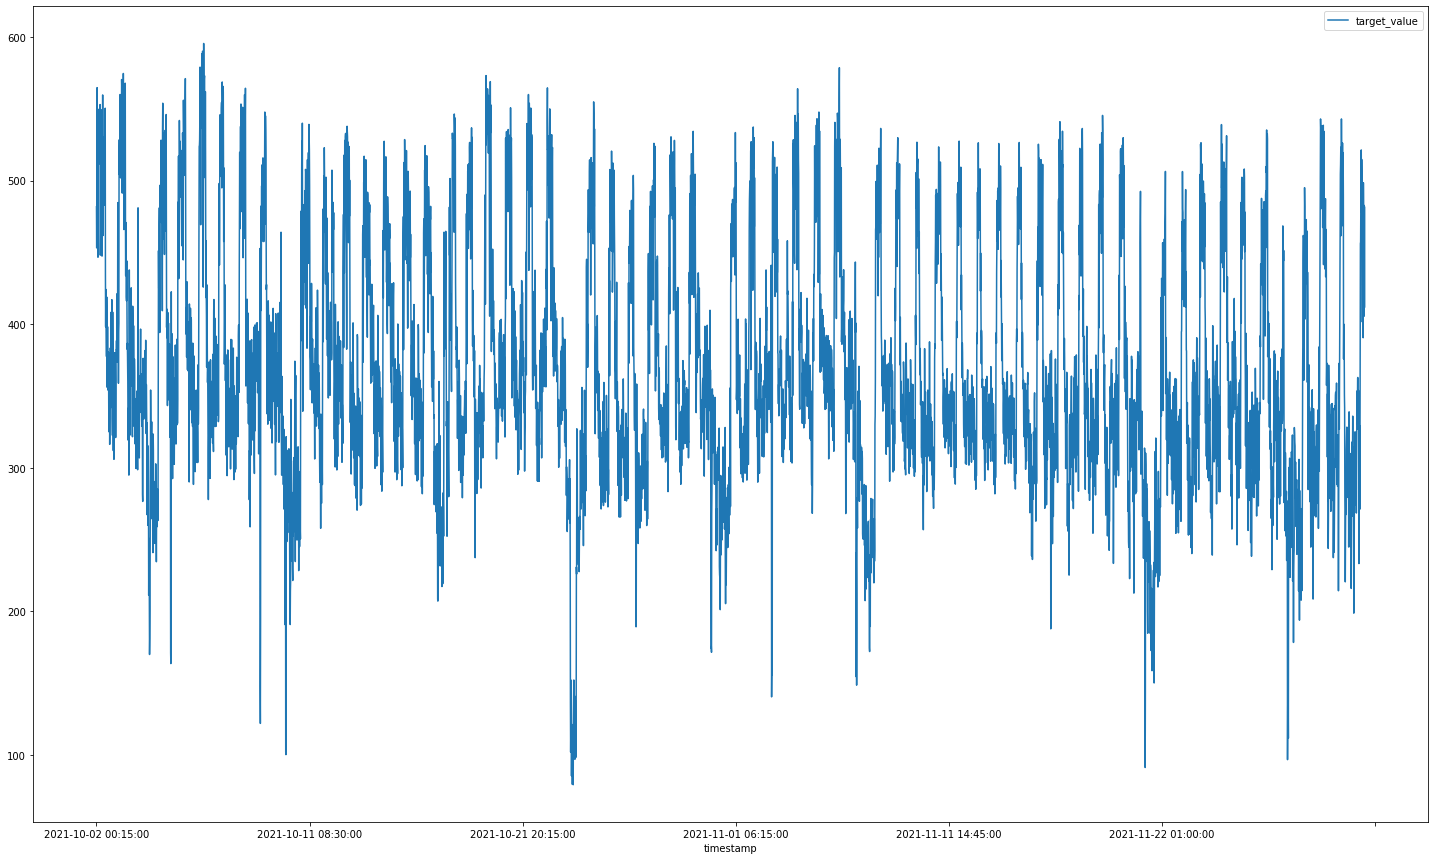

In [100]:
! pwd
!ls -l
original_df=pd.read_csv("../Rekognition/Forecast-training-data-geo-full.csv")
initial_df=original_df
ax = initial_df.plot(x='timestamp',y='target_value',figsize=(25, 15))
plt.show()